In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install openpyxl

In [ ]:
#Load data
df_inf = pd.read_csv("./kaggle/input/PCOS_infertility.csv")
df_woinf = pd.read_excel("./kaggle/input/PCOS_data_without_infertility.xlsx",sheet_name="Full_new")

In [ ]:
#Look at the data with infertile patients.
df_inf.head()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [ ]:
#Look at the data with non-infertile patients.
df_woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of aborptions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,10.48,2,5,7.0,0,0,1.99,1.99,7.95,3.68,2.160326,36,30,0.833333,0.68,2.07,45.16,17.1,0.57,92.0,0,0,0,0,0,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,11.70,2,5,11.0,1,0,60.80,1.99,6.73,1.09,6.174312,38,32,0.842105,3.16,1.53,20.09,61.3,0.97,92.0,0,0,0,0,0,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,11.80,2,5,10.0,1,0,494.08,494.08,5.54,0.88,6.295455,40,36,0.900000,2.54,6.63,10.52,49.7,0.36,84.0,0,0,0,1,1,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,12.00,2,5,4.0,0,0,1.99,1.99,8.06,2.36,3.415254,42,36,0.857143,16.41,1.22,36.90,33.4,0.36,76.0,0,0,0,0,0,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,10.00,2,5,1.0,1,0,801.45,801.45,3.98,0.90,4.422222,37,30,0.810811,3.57,2.26,30.09,43.8,0.38,84.0,0,0,0,1,0,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [ ]:
#Look at the columns of data with non-infertile patients.
df_woinf.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [ ]:
#Merge the files
data = pd.merge(df_woinf,df_inf, on='Patient File No.', suffixes={'','_wo'},how='left')
#Drop repeated features
data =data.drop(['Unnamed: 44', 'Sl. No_wo', 'PCOS (Y/N)_wo', '  I   beta-HCG(mIU/mL)_wo',
       'II    beta-HCG(mIU/mL)_wo', 'AMH(ng/mL)_wo'], axis=1)
#Change the title of the properties
data = data.rename(columns = {"PCOS (Y/N)":"Target"})
#Look at the merged data.
data.head() 

,Sl. No,Patient File No.,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of aborptions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,10.48,2,5,7.0,0,0,1.99,1.99,7.95,3.68,2.160326,36,30,0.833333,0.68,2.07,45.16,17.1,0.57,92.0,0,0,0,0,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,11.70,2,5,11.0,1,0,60.80,1.99,6.73,1.09,6.174312,38,32,0.842105,3.16,1.53,20.09,61.3,0.97,92.0,0,0,0,0,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,11.80,2,5,10.0,1,0,494.08,494.08,5.54,0.88,6.295455,40,36,0.900000,2.54,6.63,10.52,49.7,0.36,84.0,0,0,0,1,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,12.00,2,5,4.0,0,0,1.99,1.99,8.06,2.36,3.415254,42,36,0.857143,16.41,1.22,36.90,33.4,0.36,76.0,0,0,0,0,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,10.00,2,5,1.0,1,0,801.45,801.45,3.98,0.90,4.422222,37,30,0.810811,3.57,2.26,30.09,43.8,0.38,84.0,0,0,0,1,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [ ]:
#Drop unnecessary features
data = data.drop(["Sl. No","Patient File No."],axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Target                  541 non-null    int64  
 1    Age (yrs)              541 non-null    int64  
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   BMI                     541 non-null    float64
 5   Blood Group             541 non-null    int64  
 6   Pulse rate(bpm)         541 non-null    int64  
 7   RR (breaths/min)        541 non-null    int64  
 8   Hb(g/dl)                541 non-null    float64
 9   Cycle(R/I)              541 non-null    int64  
 10  Cycle length(days)      541 non-null    int64  
 11  Marraige Status (Yrs)   540 non-null    float64
 12  Pregnant(Y/N)           541 non-null    int64  
 13  No. of aborptions       541 non-null    int64  
 14    I   beta-HCG(mIU/mL)  541 non-null    fl

In [ ]:
data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [ ]:
data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [ ]:
#Converting
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

In [ ]:
colors = ['#670067','#008080']

In [ ]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    #get feature
    var = data[variable]
    #count number of categorical variable(value/sample)
    varValue = var.value_counts()
    #visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

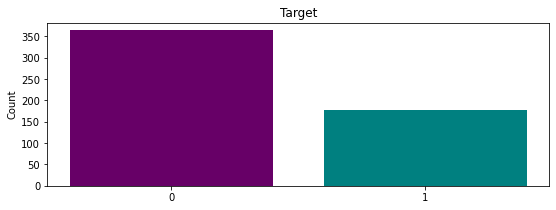

Target: 
 0    364
1    177
Name: Target, dtype: int64


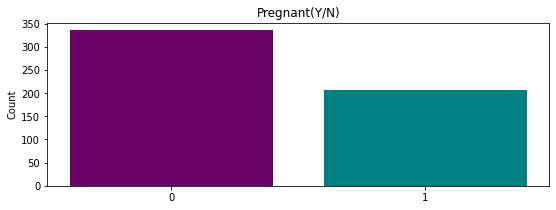

Pregnant(Y/N): 
 0    335
1    206
Name: Pregnant(Y/N), dtype: int64


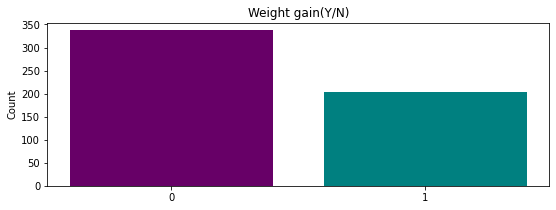

Weight gain(Y/N): 
 0    337
1    204
Name: Weight gain(Y/N), dtype: int64


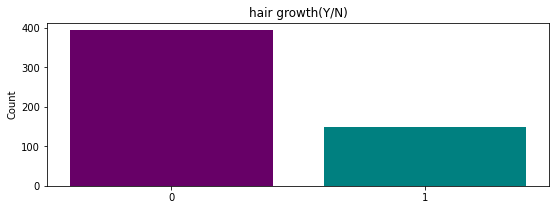

hair growth(Y/N): 
 0    393
1    148
Name: hair growth(Y/N), dtype: int64


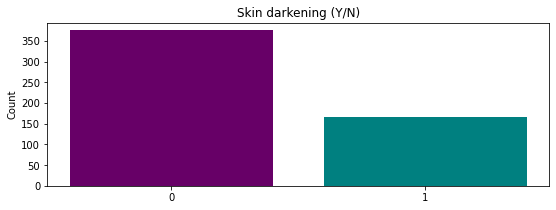

Skin darkening (Y/N): 
 0    375
1    166
Name: Skin darkening (Y/N), dtype: int64


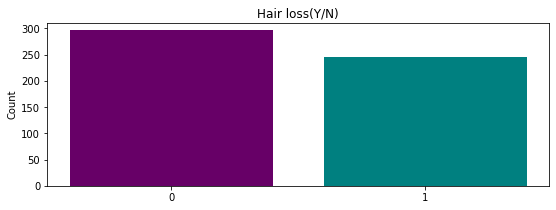

Hair loss(Y/N): 
 0    296
1    245
Name: Hair loss(Y/N), dtype: int64


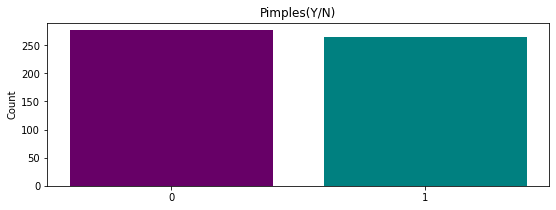

Pimples(Y/N): 
 0    276
1    265
Name: Pimples(Y/N), dtype: int64


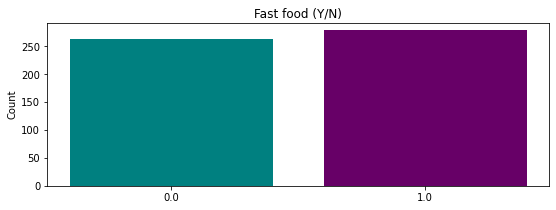

Fast food (Y/N): 
 1.0    278
0.0    262
Name: Fast food (Y/N), dtype: int64


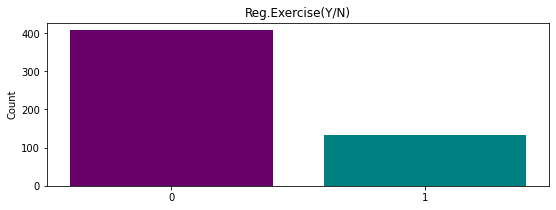

Reg.Exercise(Y/N): 
 0    407
1    134
Name: Reg.Exercise(Y/N), dtype: int64


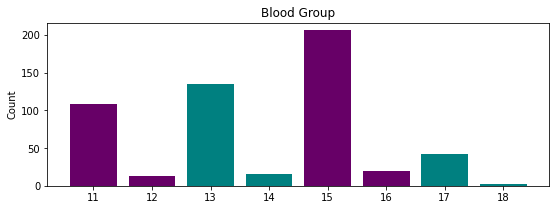

Blood Group: 
 15    206
13    135
11    108
17     42
16     19
14     16
12     13
18      2
Name: Blood Group, dtype: int64


In [ ]:
category = ["Target", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", 
            "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for c in category:
    bar_plot(c)

In [ ]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[0])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

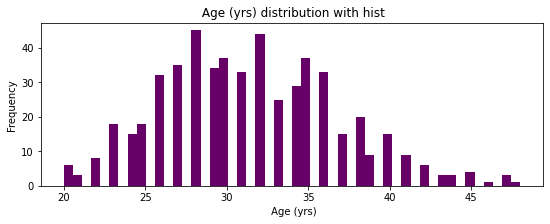

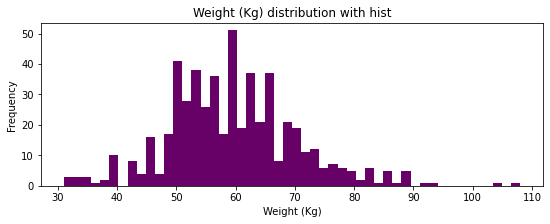

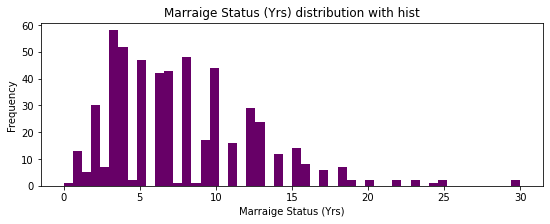

In [ ]:
numericVar = [" Age (yrs)", "Weight (Kg)","Marraige Status (Yrs)"]
for n in numericVar:
    plot_hist(n)

In [ ]:
data.columns[data.isnull().any()]

Index(['Marraige Status (Yrs)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)',
       'Fast food (Y/N)'],
      dtype='object')

In [ ]:
 #Filling missing values with the median value of the features.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)


In [ ]:
data.isnull().sum()

Target                    0
 Age (yrs)                0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     0
Pregnant(Y/N)             0
No. of aborptions         0
  I   beta-HCG(mIU/mL)    0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           0
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg) 

In [ ]:
data.describe()

,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of aborptions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.00000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,4.94085,7.679667,0.380776,0.288355,664.549235,238.232993,14.601832,6.469919,6.904831,37.992606,33.841035,0.891895,2.981281,5.620634,24.321497,49.915874,0.610945,99.835860,0.377079,0.273567,0.306839,0.452865,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,1.49202,4.799475,0.486027,0.692575,3348.920576,1603.825706,217.022081,86.673255,60.691822,3.967920,3.596894,0.046326,3.755532,5.876742,14.970391,346.206599,3.808853,18.559298,0.485104,0.446202,0.461609,0.498234,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,0.00000,0.000000,0.000000,0.000000,1.300000,0.990000,0.210000,0.020000,0.002146,26.000000,24.000000,0.755556,0.040000,0.100000,0.400000,0.000000,0.047000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,4.00000,4.000000,0.000000,0.000000,1.990000,1.990000,3.300000,1.020000,1.416244,36.000000,32.000000,0.857143,1.480000,2.010000,14.520000,20.800000,0.250000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,5.00000,7.000000,0.000000,0.000000,20.000000,1.990000,4.850000,2.300000,2.169231,38.000000,34.000000,0.894737,2.260000,3.700000,21.920000,25.900000,0.320000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,5.00000,10.000000,1.000000,0.000000,297.210000,97.630000,6.410000,3.680000,3.959184,40.000000,36.000000,0.928571,3.570000,6.900000,29.890000,34.500000,0.450000,107.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,12.00000,30.000000,1.000000,5.000000,32460.970000,25000.000000,5052.000000,2018.000000,1372.826087,48.000000,47.000000,0.979167,65.000000,66.000000,128.240000,6014.660000,85.000000,350.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


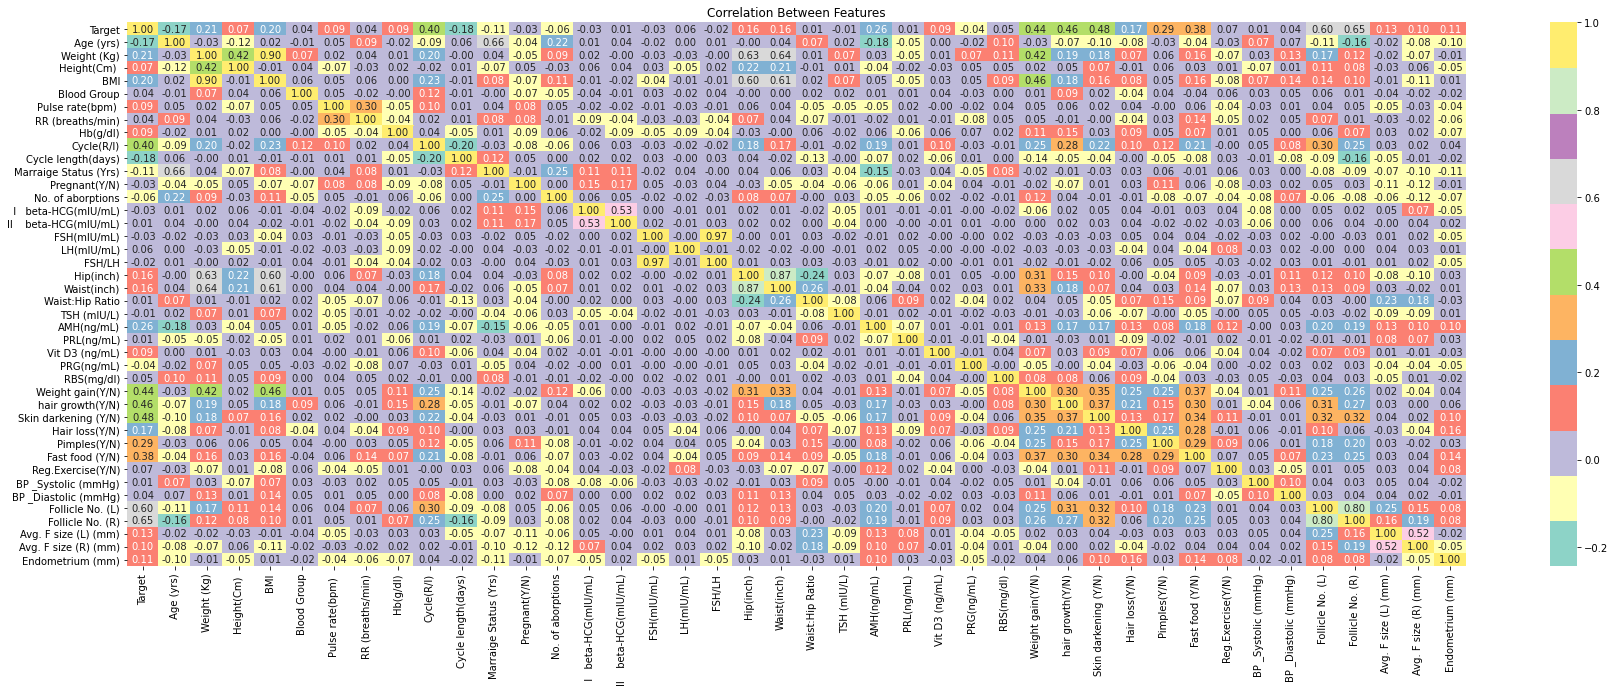

In [ ]:
corr_matrix= data.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(corr_matrix,cmap="Set3", annot = True, fmt = ".2f");
plt.title("Correlation Between Features")
plt.show()

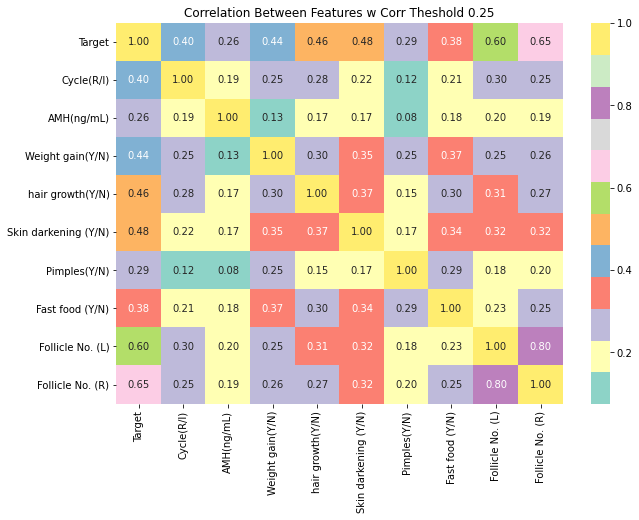

In [ ]:
threshold = 0.25 
filtre = np.abs(corr_matrix["Target"]) > threshold 
corr_features = corr_matrix.columns[filtre].tolist()
plt.subplots(figsize=(10,7))
sns.heatmap(data[corr_features].corr(),cmap="Set3", annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.25")
plt.show()

In [ ]:
X= data.drop(labels = ["Target"],axis = 1)
y=data.Target

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 

In [ ]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 378
X_test 163
y_train 378
y_test 163


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 85.98
Testing Accuracy: % 87.12


In [ ]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}


classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [ ]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(round(clf.best_score_*100,2))
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


84.15
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


69.05
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.6min finished


91.28
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


86.26
Fitting 10 folds for each of 40 candidates, totalling 400 fits
73.82


[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.2s finished


In [ ]:
best_estimators

[DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=50,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=42, splitter='best'),
 SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=8, max_features='log2',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samp

In [ ]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

In [ ]:
# xgbrf classifier
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=random_state)
xgb_clf.fit(X_train,y_train)
acc_xgb_clf_train = round(xgb_clf.score(X_train, y_train)*100,2) 
acc_xgb_clf_test = round(xgb_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_xgb_clf_train)
print("Training Accuracy: % {}".format(acc_xgb_clf_train))
print("Testing Accuracy: % {}".format(acc_xgb_clf_test))

Training Accuracy: % 91.8
Testing Accuracy: % 85.89


In [ ]:
#CatBoost Classifier
cat_clf = CatBoostClassifier()
cat_clf.fit(X_train,y_train)
acc_cat_clf_train = round(cat_clf.score(X_train, y_train)*100,2) 
acc_cat_clf_test = round(cat_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_cat_clf_train)
print("Training Accuracy: % {}".format(acc_cat_clf_train))
print("Testing Accuracy: % {}".format(acc_cat_clf_test))

Learning rate set to 0.0068
0:	learn: 0.6885995	total: 54.3ms	remaining: 54.2s
1:	learn: 0.6818852	total: 59.1ms	remaining: 29.5s
2:	learn: 0.6757997	total: 63.5ms	remaining: 21.1s
3:	learn: 0.6694094	total: 67.9ms	remaining: 16.9s
4:	learn: 0.6629133	total: 72.3ms	remaining: 14.4s
5:	learn: 0.6592207	total: 76.6ms	remaining: 12.7s
6:	learn: 0.6533582	total: 85.8ms	remaining: 12.2s
7:	learn: 0.6489357	total: 90.1ms	remaining: 11.2s
8:	learn: 0.6439968	total: 94.5ms	remaining: 10.4s
9:	learn: 0.6397804	total: 98.6ms	remaining: 9.76s
10:	learn: 0.6339426	total: 103ms	remaining: 9.24s
11:	learn: 0.6277588	total: 107ms	remaining: 8.82s
12:	learn: 0.6240759	total: 111ms	remaining: 8.46s
13:	learn: 0.6184980	total: 116ms	remaining: 8.15s
14:	learn: 0.6134301	total: 120ms	remaining: 7.88s
15:	learn: 0.6082898	total: 124ms	remaining: 7.65s
16:	learn: 0.6040465	total: 129ms	remaining: 7.44s
17:	learn: 0.6008605	total: 133ms	remaining: 7.26s
18:	learn: 0.5952161	total: 138ms	remaining: 7.11s
19:

In [ ]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','KNearestNeighbours','XGBRF','CatBoostClassifier']

In [ ]:
import plotly.graph_objects as go
# create trace1
trace1 = go.Bar(
                x = model_list,
                y = cv_result,
                marker = dict(color = 'rgb(0, 128, 128)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title = 'Accuracy of different Classifier Models' , xaxis = dict(title = 'Classifier Models'), yaxis = dict(title = '% of Accuracy'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [ ]:
model = [dt,svm,rf,lr,knn,xgb_clf,cat_clf]
predictions = []

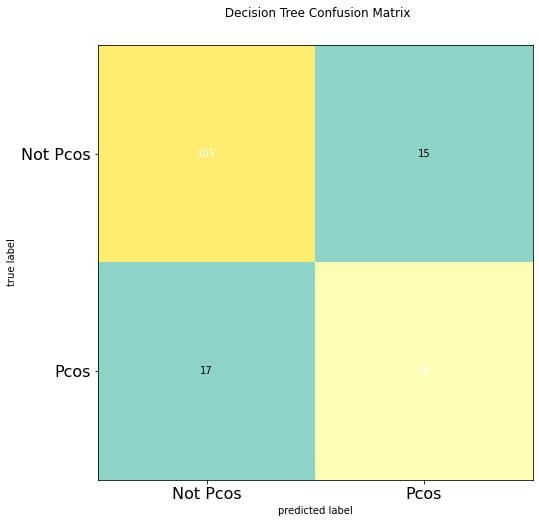

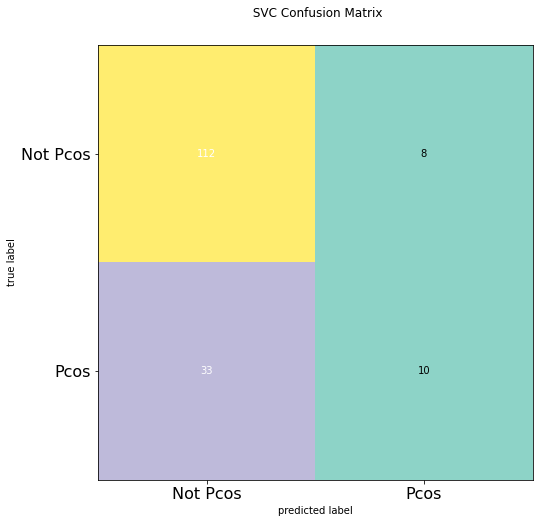

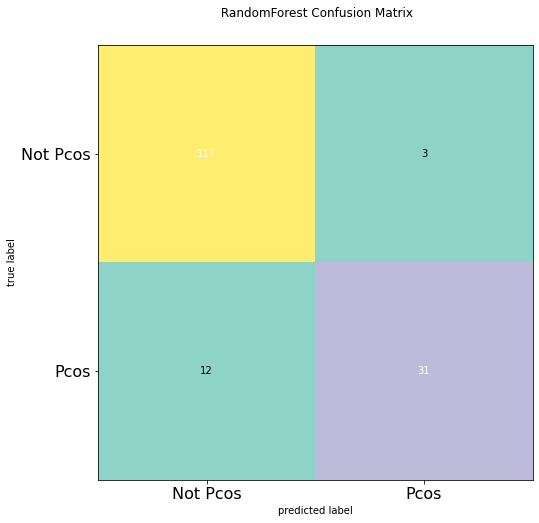

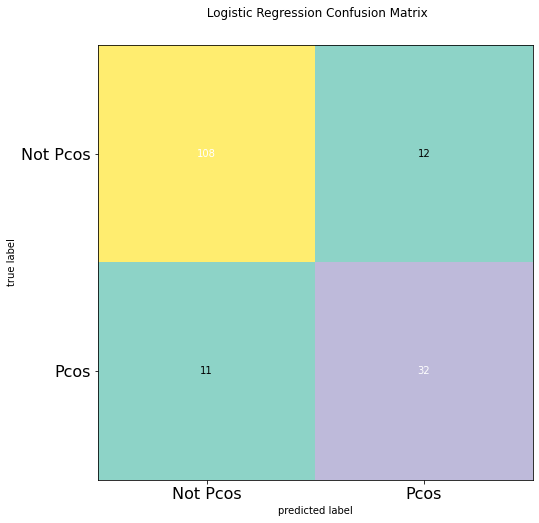

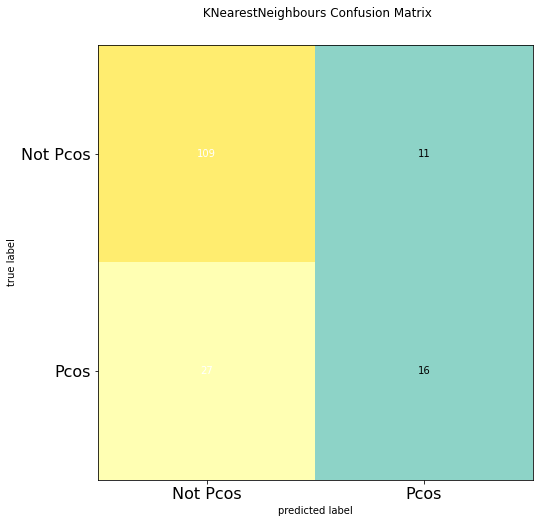

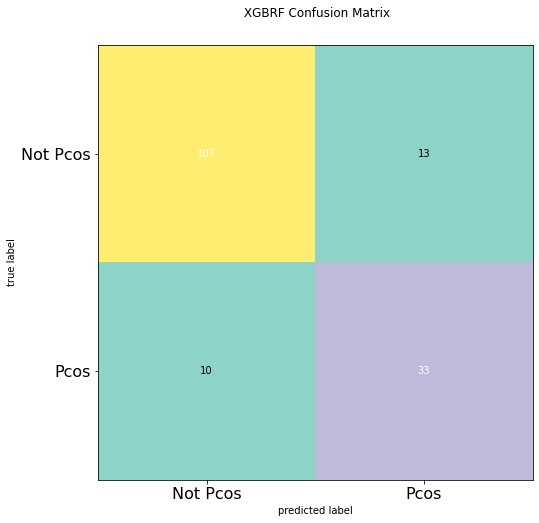

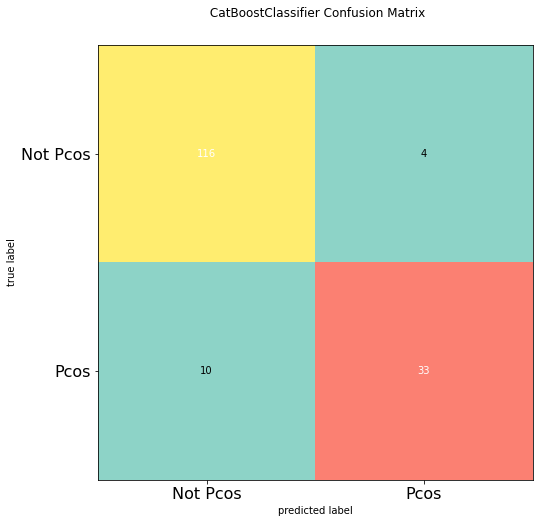

In [ ]:
for i in model:
    predictions.append(i.predict(X_test))
for j in range(7):
    cm = confusion_matrix(y_test, predictions[j])
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Set3)
    plt.title(" {} Confusion Matrix".format(model_list[j]))
    plt.xticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.yticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.show()

In [ ]:
cat_clf

In [ ]:
from sklearn.externals import joblib
joblib.dump(cat_clf, 'cat_clf.pkl')

['cat_clf.pkl']

In [ ]:
from google.colab import files
files.download("cat_clf.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of aborptions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
31,34,57.0,150.000,25.333333,11,72,22,12.0,2,4,15.0,0,0,10.00,10.00,5.01,6.48,0.773148,40,37,0.925000,4.21,1.89,12.71,32.45,0.27,85.0,1,1,1,1,1,1.0,0,110,80,5,10,14.0,13.0,6.0
379,31,55.5,151.000,24.300000,15,74,18,11.1,2,6,5.0,1,0,278.32,278.52,2.49,3.39,0.734513,38,34,0.894737,1.62,3.10,24.33,24.10,0.25,92.0,0,0,1,0,1,1.0,0,110,80,6,7,18.0,22.0,9.0
483,33,87.9,158.000,35.200000,15,72,20,10.0,4,2,8.0,0,0,70.35,1.99,2.81,0.37,7.594595,46,44,0.956522,6.55,5.75,28.05,21.00,0.21,116.0,1,0,0,0,1,1.0,0,120,80,7,12,20.0,14.0,8.0
521,40,78.0,155.000,32.500000,15,74,20,11.2,2,5,14.0,0,0,212.75,1.99,9.14,3.22,2.838509,48,46,0.958333,2.09,2.50,25.04,23.40,0.25,92.0,0,1,0,0,1,0.0,0,120,80,8,10,19.0,21.0,8.0
337,36,89.0,161.000,34.300000,15,78,24,14.0,4,3,5.0,0,0,1.99,1.99,7.10,2.22,3.198198,44,40,0.909091,4.23,2.80,10.16,35.10,0.25,130.0,1,1,1,1,1,1.0,0,110,80,16,12,11.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,38,70.0,164.592,25.800000,16,72,18,12.1,2,4,8.0,0,0,1.99,1.99,3.50,0.20,17.500000,46,42,0.913043,3.10,5.20,24.68,32.20,0.45,92.0,1,1,0,0,1,0.0,0,110,70,2,7,19.0,19.0,9.0
374,32,65.0,161.000,25.100000,11,74,20,10.2,2,6,11.0,1,0,6.19,6.19,2.17,2.02,1.074257,38,34,0.894737,4.78,0.20,99.93,17.30,0.25,115.0,1,0,0,0,1,1.0,0,110,70,1,2,13.0,14.0,7.5
327,31,55.0,161.000,21.200000,11,74,18,10.2,2,5,11.0,1,0,204.69,204.69,3.83,4.79,0.799582,37,34,0.918919,0.45,2.20,20.32,32.60,0.34,85.0,0,0,0,1,1,0.0,1,110,70,4,3,18.0,13.0,9.0
526,32,60.0,155.000,25.000000,16,74,22,10.5,4,7,4.0,1,1,83.95,1.99,3.34,2.61,1.279693,42,40,0.952381,1.52,2.50,11.20,12.70,0.25,107.0,0,1,0,0,0,0.0,0,120,80,5,3,6.8,12.0,6.8


In [ ]:
type(X_train)

pandas.core.frame.DataFrame